In [1]:
import numpy, random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, utils

In [2]:
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
from tqdm import tqdm
import os

In [4]:
df = pd.read_csv("../data/fashion-mnist/fashion-mnist_train.csv")

In [5]:
df_test = pd.read_csv("../data/fashion-mnist/fashion-mnist_test.csv")

In [24]:
pixel_columns = [f'pixel{i}' for i in range(1, 785)]
pixel_values = df[pixel_columns].values

# Flatten the pixel values into a single sequence
pixel_values = pixel_values.flatten()

# Calculate the mean and std across all pixel values
mean = numpy.mean(pixel_values)
std = numpy.std(pixel_values)

# Print the calculated mean and std
print("Mean for the entire dataset:", mean)
print("Standard Deviation for the entire dataset:", std)

Mean for the entire dataset: 72.9568306122449
Standard Deviation for the entire dataset: 89.96686298512094


In [6]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.loc[idx, "label"]
        image_pixels = self.df.loc[idx, "pixel1":].values.astype(float).reshape(28, 28, 1)  # Assuming it's a 28x28 image
        
        if self.transform:
            image_pixels = self.transform(image_pixels)

        return image_pixels, label

In [25]:
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Add the normalization transformation to the existing transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform  # Add normalization here
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform  # Add normalization here
])

In [26]:
train_loader = DataLoader(
    CustomDataset(df, transform=train_transform),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=64, shuffle=True
)

In [27]:
test_loader = DataLoader(
    CustomDataset(df_test, transform=test_transform),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=1000, shuffle=True  # You can adjust the batch size as needed
)

In [28]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [29]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 200), 
            nn.ReLU(), 
            nn.Linear(200,100),
            nn.ReLU(),
            nn.Linear(100,60), 
            nn.ReLU(), 
            nn.Linear(60, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = x.to(self.network[0].weight.dtype)
        return self.network(x)

In [30]:
print("Training on ", device)
model_fnn = FC2Layer(784, 10)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.1)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Training on  cpu
Number of parameters: 183770
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306603
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.833094
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.529217
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.598206
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.382100
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.521104
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.372942
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.483438
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.464734
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.276499

Test set: Average loss: 0.4601, Accuracy: 8388/10000 (84%)



In [31]:
classNames = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [33]:
def imshow(img, plot):
    img = img * std + mean  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(npimg[0], cmap='gray') 

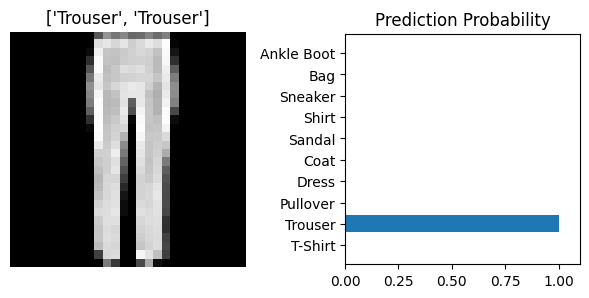

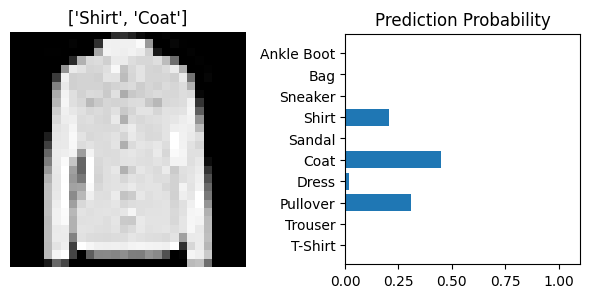

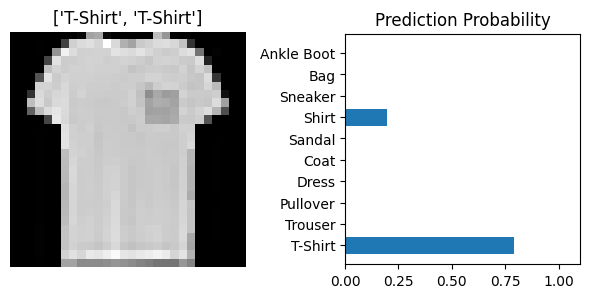

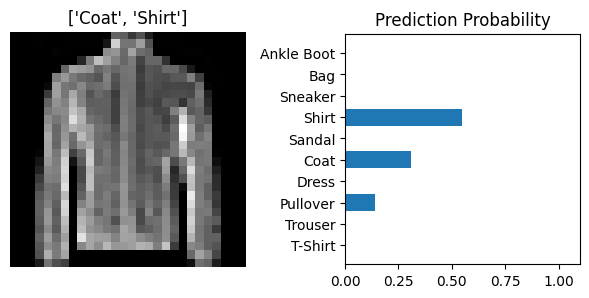

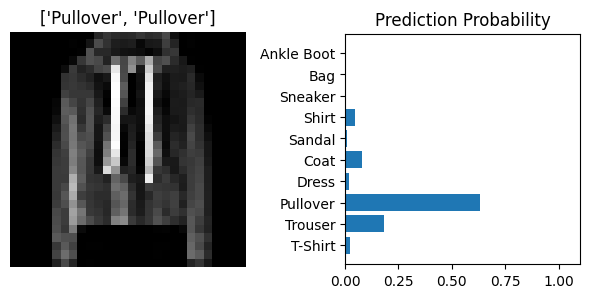

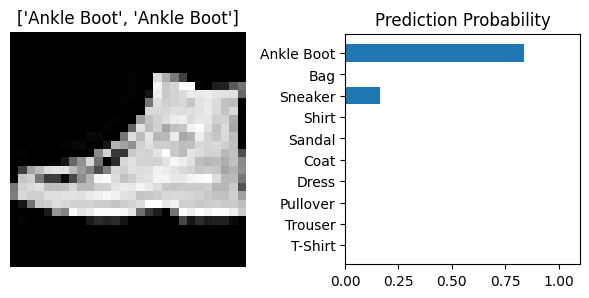

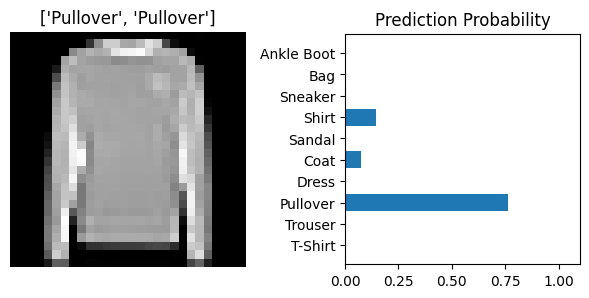

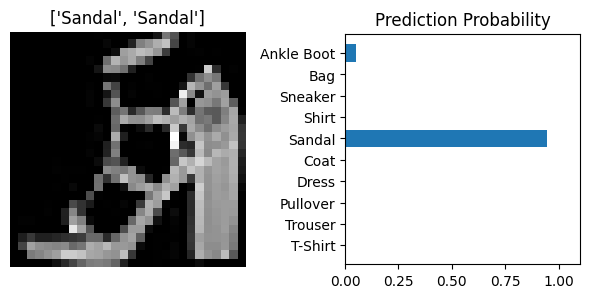

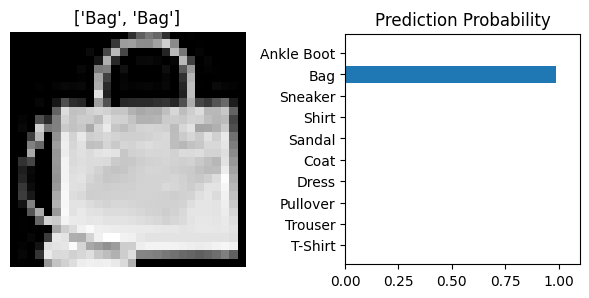

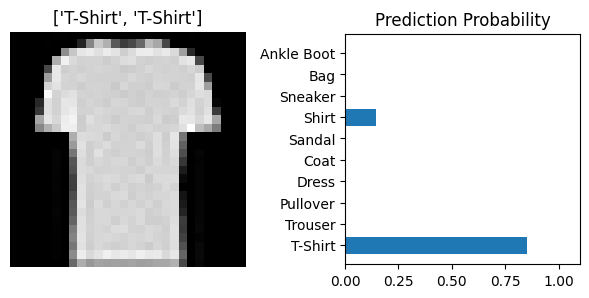

In [36]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(classNames)
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

# CNN

In [93]:
import numpy, random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms, utils

from torchinfo import summary

In [45]:
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [46]:
from tqdm import tqdm
import os

In [47]:
df = pd.read_csv("../data/fashion-mnist/fashion-mnist_train.csv")

In [48]:
df_test = pd.read_csv("../data/fashion-mnist/fashion-mnist_test.csv")

In [49]:
pixel_columns = [f'pixel{i}' for i in range(1, 785)]
pixel_values = df[pixel_columns].values

# Flatten the pixel values into a single sequence
pixel_values = pixel_values.flatten()

# Calculate the mean and std across all pixel values
mean = numpy.mean(pixel_values)
std = numpy.std(pixel_values)

# Print the calculated mean and std
print("Mean for the entire dataset:", mean)
print("Standard Deviation for the entire dataset:", std)

Mean for the entire dataset: 72.9568306122449
Standard Deviation for the entire dataset: 89.96686298512094


In [50]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.loc[idx, "label"]
        image_pixels = self.df.loc[idx, "pixel1":].values.astype(float).reshape(28, 28, 1)  # Assuming it's a 28x28 image
        
        if self.transform:
            image_pixels = self.transform(image_pixels)

        return image_pixels, label

In [51]:
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Add the normalization transformation to the existing transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform  # Add normalization here
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform  # Add normalization here
])

In [52]:
train_loader = DataLoader(
    CustomDataset(df, transform=train_transform),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=64, shuffle=True
)

In [107]:
test_loader = DataLoader(
    CustomDataset(df_test, transform=test_transform),  # Use ToTensor to convert the image to a PyTorch tensor
    batch_size=1000, shuffle=True  # You can adjust the batch size as needed
)

In [139]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.float()
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [136]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=6, padding=0)
        self.conv3 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=6, padding=0)
        self.FLATTEN_LEN=50*2*2
        self.fc1 = nn.Linear(self.FLATTEN_LEN, 10)
        # self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        #print("input", x.shape)
        
        x = self.conv1(x)      
        x = F.relu(x)
        #print("after conv1", x.shape)
        
        x = self.conv2(x)       
        x = F.relu(x)
        #print("after conv2", x.shape)
        
        x = F.max_pool2d(x, kernel_size=2)
        #print("after 1st maxpool", x.shape)
        
        x = self.conv3(x)
        x = F.relu(x)
        #print("after conv3", x.shape)
        
        x = F.max_pool2d(x, kernel_size=2)
        #print("after 2nd maxpool", x.shape)
        
        x = x.view(-1, self.FLATTEN_LEN)
        #print("after tensor shape change", x.shape)
        
        x = self.fc1(x)
        #x = F.relu(x)
        #print("after fc1", x.shape)
        
        #x = self.fc2(x)
        ##print("after fc2", x.shape)
        
        x = F.log_softmax(x, dim=0)
        return x

In [140]:
print("Training on ", device)
model_cnn = CNN(784, 10)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cpu
Number of parameters: 182610
Train Epoch: 0 [0/60000 (0%)]	Loss: 4.159441
Train Epoch: 0 [6400/60000 (11%)]	Loss: 3.139136
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.655071
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.624595
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.522683
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.568389
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.572413
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.533084
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.444919
Train Epoch: 0 [57600/60000 (96%)]	Loss: 2.546134

Test set: Average loss: 5.1860, Accuracy: 8133/10000 (81%)



In [151]:
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.C = 64
        self.network = nn.Sequential(
                # Layer 0
                nn.Conv2d(1, self.C, kernel_size=1, stride=1,
                          padding=1, bias=True),
                nn.BatchNorm2d(self.C),
                nn.ReLU(),

                # Layer 1
                nn.Conv2d(self.C, self.C*2, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*2),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 2
                nn.Conv2d(self.C*2, self.C*4, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*4),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 3
                nn.Conv2d(self.C*4, self.C*8, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*8),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 4
                nn.MaxPool2d(4, padding=1),
                Flatten(),
                nn.Linear(self.C*8, output_size, bias=True),
                nn.LogSoftmax(dim=1)
            )
    
    def forward(self, x):
        return self.network(x)

In [152]:
print("Training on ", device)
model_cnn = CNN(784, 10)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cpu
Number of parameters: 1556362
Train Epoch: 0 [0/60000 (0%)]	Loss: 3.074857
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.825714
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.617708
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.465814
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.219310
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.442928
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.334570
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.317117
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.358225
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.202028

Test set: Average loss: 0.3219, Accuracy: 8850/10000 (88%)

